In [4]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from matplotlib import animation
import math
import sys
import time
from IPython.display import clear_output
import imageio

In [5]:
def getIndexCoordinate(array, element, axis):
    """Return the position of `element` inside the array.

    Args:
        array (array): Original array that contains the element
        element (array): The element that you want to find position in array

    Returns:
        int: Position of coordinate in array
    """
    try:
        index = np.where(np.all(array == element, axis=axis))
    except Exception as e:
        print(f"Error at function `getIndexCoordinate`. arr: {array}, coord: {element}.\n{e}")
        sys.exit(1)
    else:
        return index[0]
    
    
def deathProbability(infectionTime, mean, stdDeviation):
    """ Calcula a probabilidade de morte com base na distribuição gaussiana """
    exponente = -((infectionTime - mean) ** 2) / (2 * stdDeviation ** 2)
    prob = (1 / (stdDeviation * math.sqrt(2 * math.pi))) * math.exp(exponente)
    return prob


def updateRowHuman(element, value, typeOperation, indexPassed = None):
    """Update the `value` of `element`inside the humanNP array

    Args:
        element (array): The element that you want to update
        value (array): The value
    """

    global humanNP
    global infectHuman
    global imune
    global deathNP

    index = int(value[0])
    if typeOperation == "infect":
        infectHuman = np.append(infectHuman, [value], axis=0)
        humanNP[index] = value
    elif typeOperation == "updateInfected":
        if value[-1] == 0:
            imune = np.append(imune, [[value[0], value[1], value[2], value[3], int(0.8*DAYS*-1)]], axis=0)
            humanNP[index] = [value[0], value[1], value[2], 1, int(0.8*DAYS*-1)]
            indexInfect = getIndexCoordinate(infectHuman, element, axis=1)
            infectHuman = np.delete(infectHuman, indexInfect, axis=0)
            return "deletedInfect"
        else:  
            probDeath = deathProbability(DAYS-value[4], DEATHMEAN, STDDEVIATION)
            if rd.uniform(0, 1) > 1-probDeath:
                value[3], value[4] = 0, None
                indexInfect = getIndexCoordinate(infectHuman, element, axis=1)
                infectHuman = np.delete(infectHuman, indexInfect, axis=0)
                humanNP[index] = value
                deathNP = np.append(deathNP, [value], axis=0)
                return "deletedInfect"
            else:
                infectHuman[indexPassed] = value
                humanNP[index] = value
                return "updatedInfect"
        
    elif typeOperation == "updateImune":
        if value[-1] == 0:
            indexImune = getIndexCoordinate(imune, element, axis=1)
            imune = np.delete(imune, indexImune, axis=0)
            humanNP[index][-1] = 0
            return "deletedImune"
        else:
            imune[indexPassed] = value
            humanNP[index][-1] = value[-1]
            return "updatedImune"
        
        
def toInfect(person, distance): 
    """Roll the lucky dice that has a weight attached to the person's distance from the center of radius,

    Args:
        person (array): Array that contains all information for a given person
        distance (float): The distance between person and center of radius
    """
    #print("Estou no toInfect")
    if distance < 5:
        randomReal = rd.uniform(0.5, 2)
        prob = ALPHA*randomReal
        if prob >= 0.45:
            updateRowHuman(person, [person[0], person[1], person[2], 1, DAYS], "infect")
    else:
        randomReal = rd.uniform(ALPHA*2, ALPHA*4)
        prob = ALPHA*randomReal/distance
        if prob >= 0.75:
            updateRowHuman(person, [person[0], person[1], person[2], 1, DAYS], "infect")
            print(f"{person} com uma distância de {distance} foi infectado")

    """
    numerador = ((RADIUS**2))/ALPHA
    
    randomReal = rd.uniform(numerador*0.8, 2*numerador)
    
    prob = ALPHA*(randomReal/((distance)**2))

    if prob >= 0.6:
        updateRowHuman(person, [person[0], person[1], person[2], DAYS])
        #print(f"{person} com uma distância de {distance} foi infectado")
    """ 
    
    
def checkInsideRadius(array, center, radius):
    """Check all elements of array that is inside the radius of specific `center`. If element is inside the radius, the program will call the function `toInfect` to roll the lucky dice of infect the element or not.

    Args:
        array (array): The humanNP array
        center (array): Array with the coordinates of element center
        radius (int): The Radius of element
    """
    #print("Estou no checkInsideRadius")
    Cx, Cy = center[1], center[2]
    
    for elem in array:
        if elem[4] == 0 and elem[3] == 1:
            expression = (elem[1]-Cx)**2 + (elem[2]-Cy)**2
            if expression <= radius**2:
                distance = (expression)**(0.5)
                toInfect(elem, distance)

                
def checkInfect(array, infected):
    """Check if each individue in `infected` infect other health humans
    
        Args:
        array (array): The humanNP array
        infected (array): infected
    """

    for elem in infected:
        checkInsideRadius(array, elem, RADIUS)
        
        
def toWalk():
    """It implements a walking system to the individuals
    
        Args:
        No paramater
    """
    for person in humanNP:
        if person[3] == 1:
            xRandom = rd.uniform(-tamanhoCidadeN*STEPS, tamanhoCidadeN*STEPS)
            yRandom = rd.uniform(-tamanhoCidadeM*STEPS, tamanhoCidadeM*STEPS)
            
            while not(person[1] + xRandom < 0.95*tamanhoCidadeN and person[1] + xRandom > 0.05*tamanhoCidadeN):
                xRandom = rd.uniform(-tamanhoCidadeN*STEPS, tamanhoCidadeN*STEPS)
            while not(person[2] + yRandom < 0.95*tamanhoCidadeM and person[2] + yRandom > 0.05*tamanhoCidadeM):
                yRandom = rd.uniform(-tamanhoCidadeM*STEPS, tamanhoCidadeM*STEPS)
            try:
                matchRow = np.all(person == infectHuman, axis=1)
                if np.any(matchRow):
                    try:
                        index = getIndexCoordinate(infectHuman, person, 1)[0]
                    except Exception as  e:
                        print(f"Error while doing: `index = getIndexCoordinate(infectHuman, person, 1)[0]`")
                        print(e)
                        print(f"The values:\ninfectHuman: {infectHuman}\nperson: {person}")
                        sys.exit()
                    try:
                        infectHuman[index][1] += xRandom
                        infectHuman[index][2] += yRandom
                    except Exception as e:
                        print(f"Erro while get `index` in toWalk()")
                        print(e)
                        sys.exit()
            except:
                pass
            person[1] += xRandom
            person[2] += yRandom
            
            
def create_frame(k):
    """ Creates a gif after the end of simulation
    
    Args:
    k (int): number of the image
    """
    plt.savefig(f'day_{k}.png', bbox_inches='tight')
    image = imageio.v2.imread(f'day_{k}.png')
    frames.append(image)

In [12]:
humanNP = np.empty(shape=[0, 5])
deathNP = np.empty(shape=[0, 5])
humanList = []
frames = []

rng = np.random.default_rng(12345)

tamanhoCidade = input("Tamanho da cidade no formato (nxm): ").split("x")
STEPS = float(input("Máximo de passos por dia em porcentagem decimal da própria cidade (0.0 - 1.0): "))
quantidadeHumanos = int(input("Número inicial de pessoas na simulação: "))

#areaCidade = float(tamanhoCidade[0]) * float(tamanhoCidade[1])
#quantidadeHumanos = int(round(densidadeHumanos*areaCidade, 0))

tamanhoCidadeN, tamanhoCidadeM = int(tamanhoCidade[0]), int(tamanhoCidade[1])
pessoasInfectadasAleatorias = (float(input("Número de pessoas infectadas inicialmente em porcentagem (- 100%): "))/100) * quantidadeHumanos
pessoasInfectadasAleatorias = int(round(pessoasInfectadasAleatorias, 0))


RADIUS = float(input("Raio de infecção em unidade de distância: "))
ALPHA = float(input("Taxa de infecção em porcentagem decimal da própria cidade (- 1.0): "))
DEATHMEAN = int(input("Tempo médio de morte em dias: "))
STDDEVIATION = float(input("Desvio padrão da distribuição da probabilidade de morte: "))
DAYS = int(input("Período padrão de infecção em dias: "))

numbers = []
k = 0
for i in range(quantidadeHumanos):
    while True:
        ri = round(np.random.uniform(0, tamanhoCidadeN), 2)
        rj = round(np.random.uniform(0, tamanhoCidadeM), 2)

        if (ri, rj) not in numbers:
            humanNP = np.append(humanNP, [[int(k), ri, rj, 1, 0]], axis=0)
            numbers.append((ri, rj))
            k += 1
            break

# Infecção 
listaA = []
for l in range(pessoasInfectadasAleatorias):
    numeroAleatorio = np.random.randint(0, quantidadeHumanos)
    humanNP[numeroAleatorio][-1] = DAYS
    listaA.append(humanNP[numeroAleatorio])
infectHuman = np.array(listaA)
imune = np.empty(shape=[0,5])

diasInput = int(input("Número máximo de dias para a simulação: "))

nInfectadosTempo = []
nSaudaveisTempo = []
nImunesTempo = []
nMortosTempo = []

# Decorrer dos dias
for k in range(diasInput):
    print(f"Decorreram {k} dias")
    
    nMortosTempo.append((len(deathNP), k))
    nImunesTempo.append((len(imune), k))
    nSaudaveisTempo.append((len(humanNP)-len(infectHuman)-len(imune)-len(deathNP), k))
    nInfectadosTempo.append((len(infectHuman), k))
    clear_output(wait=True)
    
    col = []
    
    for i in range(0, len(humanNP)):
        alive = humanNP[i][3] == 1
        if not alive:
            col.append("black")
        elif humanNP[i][4] == 0:
            col.append('blue')
        elif DAYS*2/3 <= humanNP[i][4] < DAYS:
            col.append('magenta')
        elif 0 < humanNP[i][4] < DAYS*2/3:
            col.append('purple')
        elif humanNP[i][4] < 0:
            col.append('green')
        else:
            col.append('red')

# Plot do gráfico
    for ll in range(len(humanNP)):
        plt.scatter(humanNP[ll][1], humanNP[ll][2], c = col[ll], s = 2, linewidth=3)
    plt.axis([0.0,tamanhoCidadeN,0,tamanhoCidadeM])
    
    
    
    ax = plt.gca()
    ax.set_autoscale_on(False)
    #plt.savefig(f"figs.{k}.png")
    
    legend_color = {
        'blue': 'Saudável',
        'red': 'Recém-infectado',
        'magenta': 'Infectado intermediário',
        'purple': 'Infectado em recuperação',
        'green': 'Imune',
        'black': 'Morto'
    }
    legend_handles = [plt.Line2D([], [], color=color, marker='o', linestyle='', markersize=5) 
                      for color in legend_color.keys()]
    plt.legend(legend_handles, legend_color.values(), loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(legend_handles))
    plt.title(f'Simulação de Evolução Epidemiológica - Dia {k}')
    create_frame(k)
    
    plt.show()
    
    #time.sleep(1)
    plt.clf()
    plt.close()
    """
    for person in humanNP:
        if person in infectHuman:
            infectHuman[person[0]] = [person[0], person[1]]
    """
    positionInfectHuman = 0
    while positionInfectHuman < len(infectHuman):
        infected = infectHuman[positionInfectHuman]
        try:
            update = updateRowHuman(infected, [infected[0], infected[1], infected[2], infected[3], infected[4]-1], "updateInfected", positionInfectHuman)
        except Exception as e:
            print(f"Error while doing: `updateRowHuman(infected, [infected[0], infected[1], infected[2], infected[4]-1])`")
            print(e)
            print(f"The value infected element: {infected}")
            sys.exit()
        if update == "updatedInfect":
            positionInfectHuman += 1
    positionImuneHuman = 0
    while positionImuneHuman < len(imune):
        personImune = imune[positionImuneHuman]
        try:
            update = updateRowHuman(personImune, [personImune[0], personImune[1], personImune[2], personImune[3], personImune[4]+1], "updateImune", positionImuneHuman)
        except:
            print(f"Error while doing: `updateRowHuman(personImune, [personImune[0], personImune[1]+1])`")
            print(e)
            print(f"The value imune element: {personImune}")
            sys.exit()
        if update == "updatedImune":
            positionImuneHuman += 1
    """
    for deleteInf in deleteInfectedHuman:
        try:
            infectHuman = np.delete(infectHuman, deleteInf, axis=0)
        except Exception as e:
            print(f"Error while executing: `infectHuman = np.delete(infectHuman, deleteInf, axis=0)`")
            print(e)
            print(f"deleteInf = {deleteInf}, infectHuman = {infectHuman}")
            input("Waiting for response")
    for deleteImu in deleteImuneHuman:
        imune = np.delete(imune, deleteImu, axis=0)
    """
    checkInfect(humanNP, infectHuman)
  
    toWalk()
    
    if nInfectadosTempo[-1][0] == 0:
        if nImunesTempo[-1][0] == 0:
            break
            
imageio.mimsave('simulation3.gif', frames, fps = 2)

Tamanho da cidade no formato (nxm):  10x10
Máximo de passos por dia em porcentagem decimal da própria cidade (0.0 - 1.0):  0.3


KeyboardInterrupt: Interrupted by user

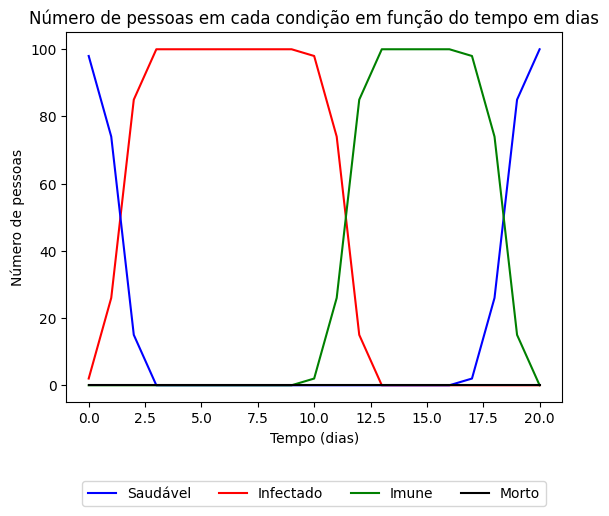

In [11]:
yInf, yS, yImu, yMort, tInf, tS, tImu, tMort = [], [], [], [], [], [], [], []
for inf in nInfectadosTempo:
    tInf.append(inf[1]), yInf.append(inf[0])
for saud in nSaudaveisTempo:
    tS.append(saud[1]), yS.append(saud[0])
for i in nImunesTempo:
    tImu.append(i[1]), yImu.append(i[0])
for m in nMortosTempo:
    tMort.append(m[1]), yMort.append(m[0])
plt.plot(tInf, yInf, "r")
plt.plot(tS, yS, "b")
plt.plot(tImu, yImu, "g")
plt.plot(tMort, yMort, "black")
ax = plt.gca()  # get the current axes
ax.relim()      # make sure all the data fits
ax.autoscale()  # auto-scale

legend_color_2 = {
    'blue': 'Saudável',
    'red': 'Infectado',
    'green': 'Imune',
    'black': 'Morto'
}
legend_handles = [plt.Line2D([], [], color=color, markersize=5) 
                  for color in legend_color_2.keys()]
plt.legend(legend_handles, legend_color_2.values(), loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(legend_handles))

ax.set_xlabel("Tempo (dias)")
ax.set_ylabel("Número de pessoas")
plt.title("Número de pessoas em cada condição em função do tempo em dias")
plt.savefig(f'simulation_graph.png', bbox_inches='tight')

plt.show()

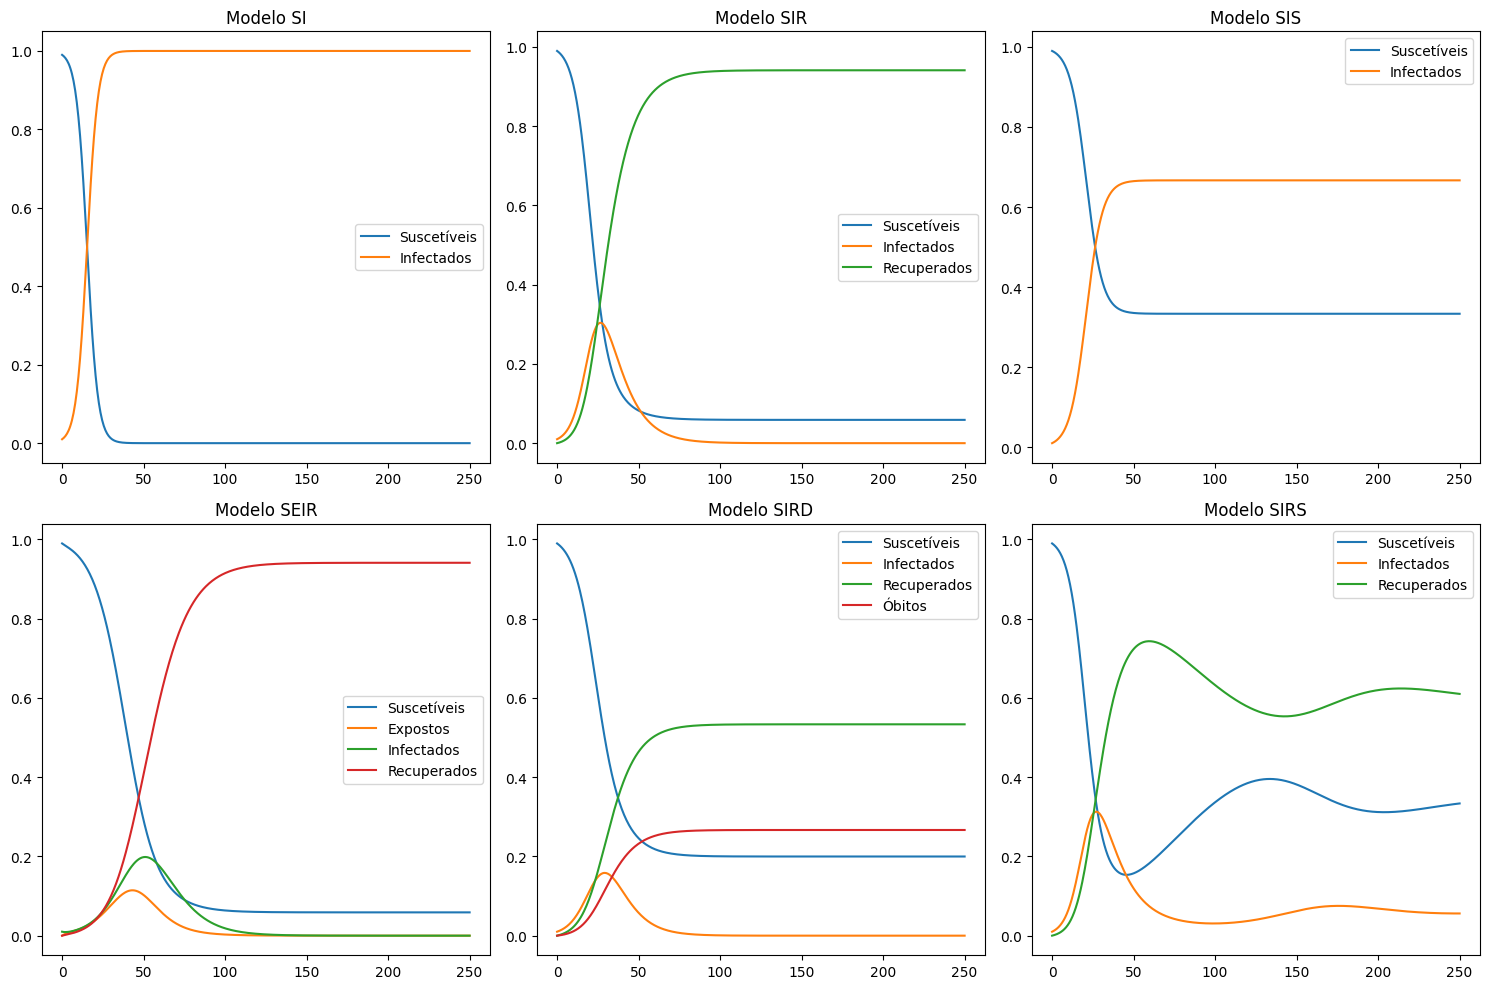

In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Funções para cada modelo
def si_model(y, t, beta):
    S, I = y
    dSdt = -beta * S * I
    dIdt = beta * S * I
    return [dSdt, dIdt]

def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def sis_model(y, t, beta, gamma):
    S, I = y
    dSdt = gamma * I - beta * S * I
    dIdt = beta * S * I - gamma * I
    return [dSdt, dIdt]

def seir_model(y, t, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

def sird_model(y, t, beta, gamma, mu):
    S, I, R, D = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dIdt, dRdt, dDdt]

def sirs_model(y, t, beta, gamma, delta):
    S, I, R = y
    dSdt = delta * R - beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I - delta * R
    return [dSdt, dIdt, dRdt]

# Parâmetros comuns
beta = 0.3  # Taxa de transmissão
gamma = 0.1  # Taxa de recuperação
sigma = 0.2  # Taxa de progressão (SEIR)
mu = 0.05    # Taxa de mortalidade (SIRD)
delta = 0.01 # Taxa de perda de imunidade (SIRS)

# Condições iniciais
N = 1.0   # População total (normalizada)
I0 = 0.01 # Infectados iniciais
S0 = N - I0
E0 = 0.0
R0 = 0.0
D0 = 0.0

# Tempo de simulação
t = np.linspace(0, 250, 500)

# Resolver cada modelo e plotar
plt.figure(figsize=(15, 10))

# SI
sol = odeint(si_model, [S0, I0], t, args=(beta,))
plt.subplot(2, 3, 1)
plt.plot(t, sol[:, 0], label='Suscetíveis')
plt.plot(t, sol[:, 1], label='Infectados')
plt.title("Modelo SI")
plt.legend()

# SIR
sol = odeint(sir_model, [S0, I0, R0], t, args=(beta, gamma))
plt.subplot(2, 3, 2)
plt.plot(t, sol[:, 0], label='Suscetíveis')
plt.plot(t, sol[:, 1], label='Infectados')
plt.plot(t, sol[:, 2], label='Recuperados')
plt.title("Modelo SIR")
plt.legend()

# SIS
sol = odeint(sis_model, [S0, I0], t, args=(beta, gamma))
plt.subplot(2, 3, 3)
plt.plot(t, sol[:, 0], label='Suscetíveis')
plt.plot(t, sol[:, 1], label='Infectados')
plt.title("Modelo SIS")
plt.legend()

# SEIR
sol = odeint(seir_model, [S0, E0, I0, R0], t, args=(beta, sigma, gamma))
plt.subplot(2, 3, 4)
plt.plot(t, sol[:, 0], label='Suscetíveis')
plt.plot(t, sol[:, 1], label='Expostos')
plt.plot(t, sol[:, 2], label='Infectados')
plt.plot(t, sol[:, 3], label='Recuperados')
plt.title("Modelo SEIR")
plt.legend()

# SIRD
sol = odeint(sird_model, [S0, I0, R0, D0], t, args=(beta, gamma, mu))
plt.subplot(2, 3, 5)
plt.plot(t, sol[:, 0], label='Suscetíveis')
plt.plot(t, sol[:, 1], label='Infectados')
plt.plot(t, sol[:, 2], label='Recuperados')
plt.plot(t, sol[:, 3], label='Óbitos')
plt.title("Modelo SIRD")
plt.legend()

# SIRS
sol = odeint(sirs_model, [S0, I0, R0], t, args=(beta, gamma, delta))
plt.subplot(2, 3, 6)
plt.plot(t, sol[:, 0], label='Suscetíveis')
plt.plot(t, sol[:, 1], label='Infectados')
plt.plot(t, sol[:, 2], label='Recuperados')
plt.title("Modelo SIRS")
plt.legend()

plt.tight_layout()
plt.show()